In [8]:

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [9]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [10]:

# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        # gravity tensor, only affects the second state
        delta_state_gravity = -0.5 * (FRAME_TIME ** 2) * GRAVITY_ACCEL * t.tensor([0., 1., 0., 0., 0.])

        # first action tensor
        sin_value = t.sin(state[4])
        cos_value = t.cos(state[4])

        state_tensor = t.tensor([-0.5 * (FRAME_TIME ** 2) * sin_value,
                                    0.5 * (FRAME_TIME ** 2) * cos_value,
                                    -FRAME_TIME * sin_value,
                                    FRAME_TIME * cos_value, 0.])

        delta_state = BOOST_ACCEL * t.mul(state_tensor,action[0])

        # Second action tensor
        delta_state_theta = t.mul(t.tensor([0., 0., 0., 0., 1.]), action[1])

        # update state
        state = state + delta_state + delta_state_gravity + delta_state_theta

        # step forward
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                             [0., 1., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0.],
                             [0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat,state)
       
        return state

In [11]:


# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


In [12]:

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1, 1, 0.3, 0.3, -0.1]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        weights = t.tensor([1,1,2,2,10])
        return weights[0] * state[0]**2 + weights[1]* state[1]**2 + weights[2] * state[2]**2 + weights[3] * state[3]**2 + weights[4] * state[4]**2

In [13]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.001)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        plt.plot(data[:, 0],label='x1')
        plt.plot(data[:, 1],label='x2')
        plt.plot(data[:, 2],label='x3')
        plt.plot(data[:, 3],label='x4')
        plt.plot(data[:, 4],label='x5')
        plt.legend()
        plt.show()



[1] loss: 30187.201
[2] loss: 8923.940
[3] loss: 5076.708
[4] loss: 4818.071
[5] loss: 4389.971
[6] loss: 3959.724
[7] loss: 3622.697
[8] loss: 3345.688
[9] loss: 3064.467
[10] loss: 2713.062
[11] loss: 2439.864
[12] loss: 2238.237
[13] loss: 2071.285
[14] loss: 1923.555
[15] loss: 1780.551
[16] loss: 1629.418
[17] loss: 1499.344
[18] loss: 1390.279
[19] loss: 1293.430
[20] loss: 1207.365
[21] loss: 1122.554
[22] loss: 1039.566
[23] loss: 968.233
[24] loss: 902.339
[25] loss: 841.275
[26] loss: 789.148
[27] loss: 728.100
[28] loss: 652.875
[29] loss: 591.020
[30] loss: 526.298
[31] loss: 421.967
[32] loss: 381.233
[33] loss: 359.055
[34] loss: 344.885
[35] loss: 333.773
[36] loss: 323.775
[37] loss: 314.504
[38] loss: 304.962
[39] loss: 294.304
[40] loss: 283.715


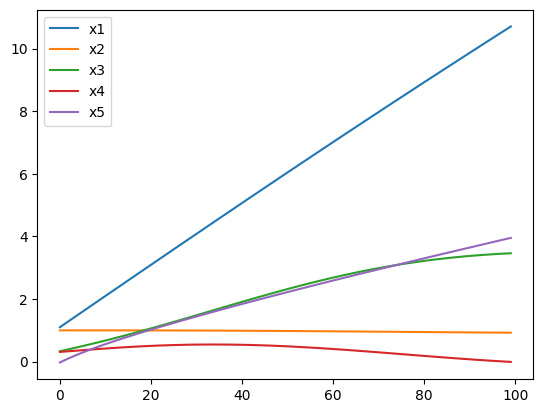

In [14]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem


